<a href="https://colab.research.google.com/github/yuji-sgs/child-mind-institute/blob/main/Feature_Enginnering/LGBM_non_parquet_ver01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install colorama catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

In [321]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/test.csv')
data_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/data_dictionary.csv')
sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Child Mind Institute/data/sample_submission.csv')

# 前処理

In [322]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [323]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

In [324]:
train[['sii']].value_counts()

,count
sii,
0.0,1594
1.0,730
2.0,378
3.0,34


In [325]:
train[['sii']].isnull().sum()

,0
sii,1224


In [326]:
train = train[featuresCols]
test = test[featuresCols[:-1]]
train = train.dropna(subset='sii') # siiが欠損する行を削除

In [327]:
train[['sii']].isnull().sum()

,0
sii,0


In [328]:
# 季節に関する特徴量
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season',
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

In [329]:
# カテゴリ型に変換
def update(df):
    for c in cat_c:
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

In [330]:
# カテゴリデータを数値データに変換
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)

    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (2736, 59) || Test Shape : (20, 58)


In [331]:
train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,2.0
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,0.0
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,0.0
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0,1.0
5,3,13,1,0,50.0,1,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,0,NaN,NaN,NaN,1,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,3,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,0,NaN,4,4.110,2,40.0,56.0,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,0,8,0,1,NaN,0,17.139810,52.5,67.2,25.0,60.0,65.0,112.0,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,0,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,0,NaN,1,3.440,1,41.0,58.0,0,2.0,0.0
3954,1,7,1,1,NaN,1,13.927006,48.5,46.6,23.0,65.0,75.0,105.0,0,NaN,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,9.0,0.0,8.5,0.0,4.5,0.0,0,1.0,2.36680,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.41470,1.0,20.0572,15.14000,42.8185,18.0937,30.0453,0,NaN,0,NaN,2,48.0,67.0,1,0.0,1.0
3955,0,13,0,4,60.0,0,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,0,NaN,NaN,NaN,0,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,0,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.301380,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,0,NaN,3,3.260,3,35.0,50.0,0,1.0,1.0
3957,0,11,0,4,68.0,3,21.441500,60.0,109.8,NaN,79.0,99.0,116.0,0,NaN,NaN,NaN,2,15.0,1.0,18.5,2.0,15.8,2.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,1,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.639520,33.99670,2.0,33.9805,21.34030,71.3903,28.7792,54.4630,0,NaN,3,2.729,3,56.0,77.0,0,0.0,1.0


In [332]:
test

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,0,5,0,0,51.0,0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0
1,1,9,0,1,NaN,0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0
2,1,10,1,2,71.0,0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0
3,2,9,0,2,71.0,1,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0
4,3,18,1,3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.04,0,NaN,0,NaN,NaN,3,NaN
5,3,13,1,0,50.0,1,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,0,NaN,NaN,NaN,1,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,3,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,0,NaN,4,4.110,2,40.0,56.0,4,0.0
6,0,10,0,1,NaN,0,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,0,NaN,NaN,NaN,0,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,0,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,0,NaN,3,3.670,3,27.0,40.0,0,3.0
7,0,10,1,1,NaN,0,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,0,NaN,NaN,NaN,0,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,0,NaN,1,1.270,0,NaN,NaN,0,2.0
8,1,15,0,1,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,NaN,1,2.0
9,1,19,1,3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,NaN,3,NaN


# Feature Enginnering

In [335]:
def feature_engineering(df):
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    return df

In [336]:
train = feature_engineering(train)
test = feature_engineering(test)

# LGBM

In [337]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [357]:
Params7 = {'objective':'regression', 'learning_rate': 0.05, 'max_depth': -1, 'num_leaves': 31, 'min_data_in_leaf': 14,
           'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5,
           'lambda_l1': 10, 'lambda_l2': 0.01}

Light = lgb.LGBMRegressor(**Params7,random_state=SEED, verbose=-1,n_estimators=200)

In [358]:
X = train.drop(['sii'], axis=1)
y = train['sii']

# 層化交差検証
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# 各フォールドでの訓練・検証スコアを保存するリスト。
train_S = []
test_S = []

# 検証データの予測値を保存する配列。
oof_non_rounded = np.zeros(len(y), dtype=float)
oof_rounded = np.zeros(len(y), dtype=int)

# テストデータの予測値を保存する配列。
test_preds = np.zeros((len(test), n_splits))

for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

    model = clone(Light)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    oof_non_rounded[test_idx] = y_val_pred
    y_val_pred_rounded = y_val_pred.round(0).astype(int)
    oof_rounded[test_idx] = y_val_pred_rounded

    train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
    val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

    train_S.append(train_kappa)
    test_S.append(val_kappa)

    test_preds[:, fold] = model.predict(test)

    print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
    clear_output(wait=True)

Training Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


In [359]:
print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

KappaOPtimizer = minimize(evaluate_predictions,
                          x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded),
                          method='Nelder-Mead') # Nelder-Mead | # Powell
assert KappaOPtimizer.success, "Optimization did not converge."

oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
tKappa = quadratic_weighted_kappa(y, oof_tuned)

print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

tpm = test_preds.mean(axis=1)
tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

submission = pd.DataFrame({
    'id': sample['id'],
    'sii': tpTuned
})

Mean Train QWK --> 0.6977
Mean Validation QWK ---> 0.4072
----> || Optimized QWK SCORE ::  0.456


In [192]:
KappaOPtimizer.x

array([0.52753096, 1.08348757, 2.73882006])

In [ ]:
tpm

array([0.85695684, 0.20893048, 0.38104058, 0.42992455, 0.59714034,
       0.80475794, 0.38046422, 0.21393417, 0.86505232, 0.60260741,
       0.44016478, 0.46835829, 0.94363281, 0.69550153, 0.79147883,
       1.05849122, 0.06661363, 0.17155723, 0.36610367, 0.63617597])

In [ ]:
tpTuned

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

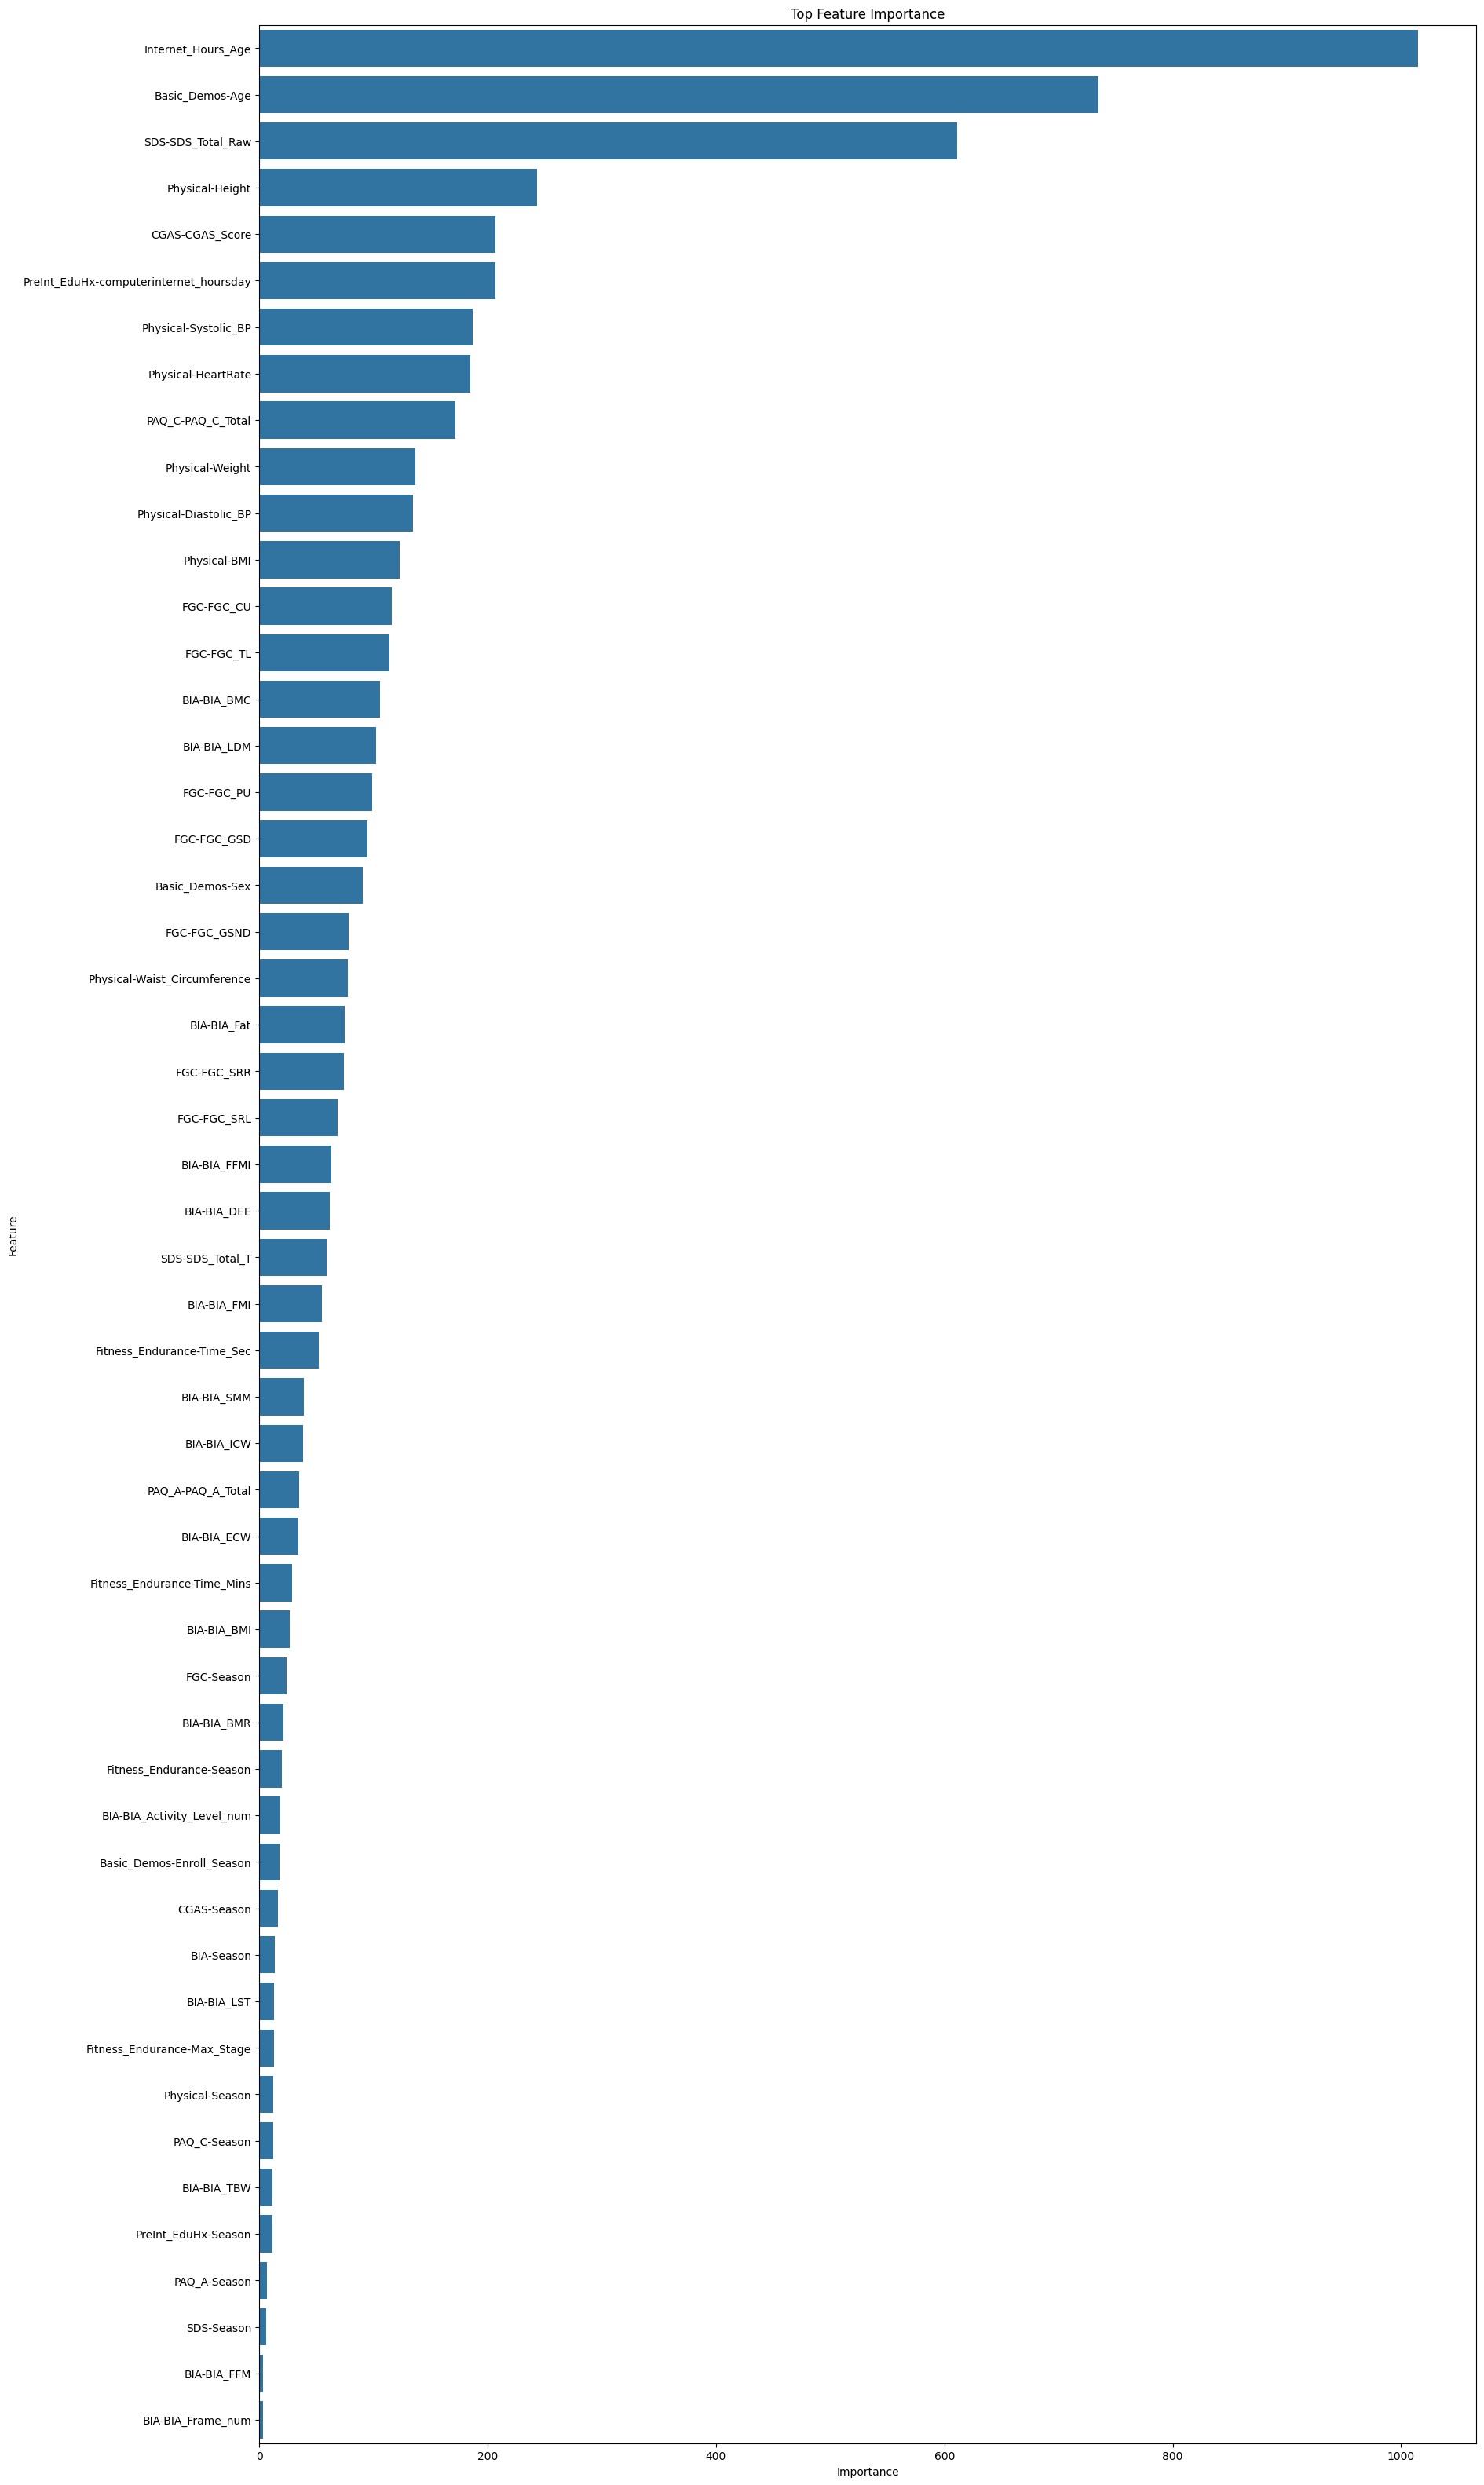

CPU times: user 1.46 s, sys: 118 ms, total: 1.58 s
Wall time: 2.08 s


In [174]:
%%time

feature_importance_df = pd.DataFrame({
    'Feature': model.booster_.feature_name(),
    'Importance': model.booster_.feature_importance(importance_type='gain')
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 40))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title("Top Feature Importance")
plt.show()
